In [123]:
import numpy as np
from scipy.linalg import norm
from matplotlib import pyplot as plt
from scipy import sparse

# Problem 1-2

In [237]:
def jacobi(A, b, tol=1e-8, maxiters=100, plot=False):
    if np.any(np.diag(A) == 0):
        raise ValueError("A must have nonzero diagonal entries")
    D = np.diag(A)  # diagonal of A
    
    i = 0
    dist = 1e3
    x_k = np.zeros_like(b)
    errors = np.empty(maxiters)
    while dist >= tol and i < maxiters:
        x_k1 = x_k + (b - A @ x_k) / D
        errors[i] = norm(x_k1 - x_k, np.inf)
        dist = errors[i]
        x_k = x_k1
        i += 1
        
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(np.arange(i), errors[:i])
        plt.semilogy()
        plt.title("Convergence of Jacobi Method", fontsize=15)
        plt.xlabel("Iteration")
        plt.ylabel("Absolute Error of Approximation")
        plt.show()
        
    return x_k

In [238]:
def diag_dom(n, num_entries=None):
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

In [239]:
n = 5000
b = np.random.random(n)
A = diag_dom(n)

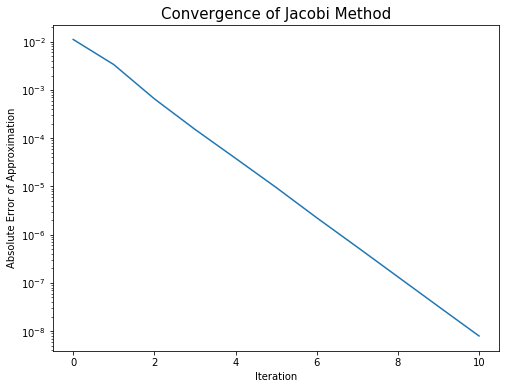

In [240]:
x = jacobi(A, b, plot=True)

In [241]:
np.allclose(A @ x, b, atol=1e-6)

True

# Problem 3

In [233]:
def gauss_seidel(A, b, tol=1e-8, maxiters=100, plot=False):
    if np.any(np.diag(A) == 0):
        raise ValueError("A must have nonzero diagonal entries")
    
    j = 0
    dist = 1e3
    x_k = np.zeros_like(b)
    errors = np.empty(maxiters)
    while dist >= tol and j < maxiters:
        x_k_copy = x_k.copy()
        x_k1 = np.array([x_k[i] + (1 / A[i, i]) * (b[i] - A[i] @ x_k) for i in range(len(x_k))])
        errors[j] = norm(x_k1 - x_k_copy, np.inf)
        dist = errors[j]
        x_k = x_k1
        j += 1

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(np.arange(j), errors[:j])
        plt.semilogy()
        plt.title("Convergence of Gauss-Seidel Method", fontsize=15)
        plt.xlabel("Iteration")
        plt.ylabel("Absolute Error of Approximation")
        plt.show()
        
    return x_k

In [234]:
n = 5000
b = np.random.random(n)
A = diag_dom(n)

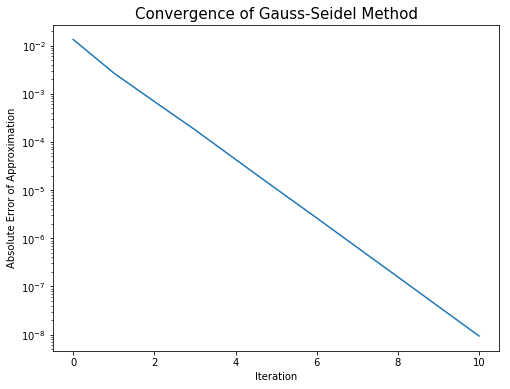

In [235]:
x = gauss_seidel(A, b, plot=True)

In [236]:
np.allclose(A @ x, b, atol=1e-6)

True

# Problem 4

In [149]:
def sparse_gauss_seidel(A, b, tol=1e-8, maxiters=100):
    j = 0
    dist = 1e3
    x_k = np.zeros_like(b)
    x_k1 = np.empty_like(x_k)
    while dist >= tol and j < maxiters:
        x_k_copy = x_k.copy()
        for i in range(len(b)):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix = A.data[rowstart:rowend] @ x_k[A.indices[rowstart:rowend]]
            x_k1[i] = x_k[i] + (1 / A[i, i]) * (b[i] - Aix)
        dist = norm(x_k1 - x_k_copy, np.inf)
        x_k = x_k1
        j += 1

    return x_k

In [150]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)

In [151]:
x = sparse_gauss_seidel(A, b)

In [152]:
np.allclose(A @ x, b, atol=1e-6)

True

# Problem 5

In [226]:
def SOR(A, b, ω, tol=1e-8, maxiters=100):
    A = sparse.csr_matrix(A)
    j = 0
    dist = 1e3
    x_k = np.zeros_like(b)
    x_k1 = np.empty_like(x_k)
    while dist >= tol and j < maxiters:
        x_k_copy = x_k.copy()
        for i in range(len(b)):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix = A.data[rowstart:rowend] @ x_k[A.indices[rowstart:rowend]]
            x_k1[i] = x_k[i] + (ω / A[i, i]) * (b[i] - Aix)
        dist = norm(x_k1 - x_k_copy, np.inf)
        x_k = x_k1
        j += 1

    return x_k, j

In [227]:
A = diag_dom(5000)
b = np.random.random(5000)

In [228]:
ω = 1
x, i = SOR(A, b, ω)

In [229]:
np.allclose(A @ x, b, atol=1e-6)

True

In [230]:
print(f"Number of iterations computed: {i}")

Number of iterations computed: 9


# Problem 6

In [252]:
def laplace(n, ω, tol=1e-8, maxiters=100, plot=False):
    A_diag = -n * np.eye(n) + np.eye(n, k=-1) + np.eye(n, k=1)
    A_off_diag = np.eye(n**2, k=-n) + np.eye(n**2, k=n)
    A = np.zeros((n**2, n**2))
    for i in range(0, n**2, n):
        A[i:i+n, i:i+n] = A_diag
    A = A + A_off_diag
    b = np.zeros(n)
    b[0], b[-1] = -100, -100
    b = np.tile(b, n)
    u, i = SOR(A, b, ω, tol, maxiters)
    
    if plot:
        plt.pcolormesh(u.reshape((n, n)), cmap='coolwarm')
        plt.show()
    
    return u, i

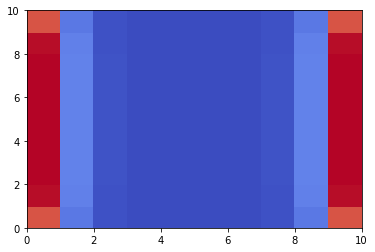

In [260]:
u, i = laplace(10, 1, plot=True)

In [262]:
print(f'Distribution of heat at steady state:\n {u}')

Distribution of heat at steady state:
 [1.13874983e+01 1.31075137e+00 1.52337791e-01 1.78865874e-02
 2.35984892e-03 2.35984944e-03 1.78865887e-02 1.52337792e-01
 1.31075137e+00 1.13874983e+01 1.25642316e+01 1.56767766e+00
 1.94739959e-01 2.41682487e-02 3.35206497e-03 3.35206564e-03
 2.41682504e-02 1.94739961e-01 1.56767766e+00 1.25642316e+01
 1.26871398e+01 1.60705368e+00 2.03215907e-01 2.57038911e-02
 3.64049920e-03 3.64049984e-03 2.57038927e-02 2.03215909e-01
 1.60705368e+00 1.26871398e+01 1.27001123e+01 1.61250348e+00
 2.04661559e-01 2.60142694e-02 3.70854648e-03 3.70854698e-03
 2.60142707e-02 2.04661561e-01 1.61250348e+00 1.27001123e+01
 1.27014800e+01 1.61320726e+00 2.04881947e-01 2.60687074e-02
 3.72215631e-03 3.72215663e-03 2.60687083e-02 2.04881948e-01
 1.61320726e+00 1.27014800e+01 1.27014800e+01 1.61320726e+00
 2.04881947e-01 2.60687079e-02 3.72215665e-03 3.72215683e-03
 2.60687084e-02 2.04881948e-01 1.61320726e+00 1.27014800e+01
 1.27001123e+01 1.61250348e+00 2.04661561e-01 

In [263]:
print(f'Number of iterations computed: {i}')

Number of iterations computed: 15


# Problem 7

In [267]:
ω_list = np.arange(1, 2, 0.05)
n = 20

In [268]:
iterations = np.empty_like(ω_list)
for i, ω in enumerate(ω_list):
    iterations[i] = laplace(n, ω, tol=1e-2, maxiters=1000)[1]

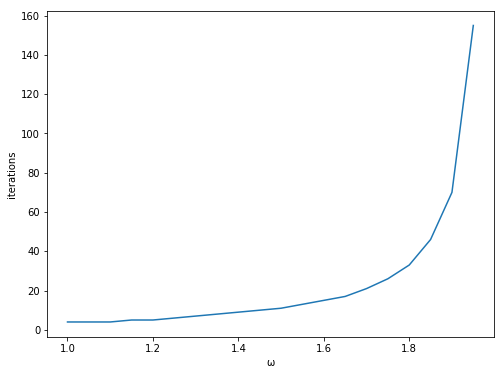

In [272]:
plt.figure(figsize=(8, 6))
plt.plot(ω_list, iterations)
plt.xlabel("ω")
plt.ylabel("iterations")
plt.show()

In [276]:
ω_list[np.argmin(iterations)]

1.0